### Подключение к базе и основные таблицы

In [1]:
import pandas as pd

# Данные по пользователям

user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [2]:
# Посты и топики

posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [3]:
# Количество записей в таблице feed_data
count_feed_data = pd.read_sql(
    """SELECT count(*) FROM public.feed_data""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

count_feed_data.head()

,count
0,76892800


In [4]:
# Берем первые 5 миллионов записей

feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 5000000""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-12 09:33:11,161136,6415,view,0
1,2021-11-12 09:36:05,161136,480,view,0
2,2021-11-12 09:38:07,161136,3130,view,0
3,2021-11-12 09:40:19,161136,1656,view,0
4,2021-11-18 09:34:31,161136,4869,view,0


### Работа с данными и фичи для контентной модели

In [5]:
# Смотрим как устроена колонка target

feed_data[feed_data.action!='view']

,timestamp,user_id,post_id,action,target
13,2021-11-18 09:53:26,161136,682,like,0
15,2021-11-18 09:55:14,161136,5357,like,0
17,2021-11-18 09:57:35,161136,5353,like,0
20,2021-11-18 09:59:55,161136,733,like,0
25,2021-11-18 10:05:17,161136,6717,like,0
...,...,...,...,...,...
4999983,2021-11-20 14:04:45,84508,5455,like,0
4999988,2021-11-21 19:38:50,84508,1388,like,0
4999990,2021-11-21 19:41:24,84508,2872,like,0
4999992,2021-11-21 19:43:46,84508,1300,like,0


In [6]:
# Почистим данные от action != view

feed_data = feed_data[feed_data.action=='view']

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-12 09:33:11,161136,6415,view,0
1,2021-11-12 09:36:05,161136,480,view,0
2,2021-11-12 09:38:07,161136,3130,view,0
3,2021-11-12 09:40:19,161136,1656,view,0
4,2021-11-18 09:34:31,161136,4869,view,0


In [7]:
# Необходимо по user_id выделять 
# Фиксированный набор признаков
# В целом, подойдет оригинальный датасет

user_info

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [8]:
# В таблице post_id преобразуем текст в эмбеддинги

posts_info

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [9]:
import re
import string

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

In [10]:
import nltk

tfidf_data = (
    tfidf
    .fit_transform(posts_info['text'])
    .toarray()
)

tfidf_data

C:\Users\slava\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13273932, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05061394, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [11]:
tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7316,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7317,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Генерим фичи на основе TfIdf

posts_info['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
posts_info['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138


In [13]:
[f"DistanceTo{ith}thCluster" for ith in range(1, 16)]

['DistanceTo1thCluster',
 'DistanceTo2thCluster',
 'DistanceTo3thCluster',
 'DistanceTo4thCluster',
 'DistanceTo5thCluster',
 'DistanceTo6thCluster',
 'DistanceTo7thCluster',
 'DistanceTo8thCluster',
 'DistanceTo9thCluster',
 'DistanceTo10thCluster',
 'DistanceTo11thCluster',
 'DistanceTo12thCluster',
 'DistanceTo13thCluster',
 'DistanceTo14thCluster',
 'DistanceTo15thCluster']

In [14]:
# Пытаемся кластеризовать тексты

from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

posts_info['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

C:\Users\slava\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.480950,0.393620,0.511005,0.452230,0.435448,0.508004,0.153318,0.499247,0.528825,0.531872,0.535601,0.451062,0.440469,0.467098,0.545162
1,0.347944,0.166929,0.389362,0.314780,0.284017,0.425945,0.265324,0.384865,0.417226,0.283954,0.433196,0.305134,0.288670,0.340473,0.448996
2,0.363351,0.230754,0.398966,0.333496,0.304436,0.430344,0.127246,0.398547,0.432524,0.479071,0.449855,0.342907,0.319707,0.345712,0.478959
3,0.324441,0.144675,0.365146,0.279130,0.254276,0.406850,0.230317,0.330804,0.385887,0.433351,0.417854,0.290832,0.283966,0.308295,0.444929
4,0.260389,0.100852,0.306887,0.196474,0.155442,0.353807,0.285260,0.296983,0.343361,0.391938,0.406265,0.236587,0.211668,0.240808,0.399030


In [15]:
posts_info = pd.concat((posts_info,dists_df), axis=1)

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,6,0.480950,0.393620,0.511005,...,0.508004,0.153318,0.499247,0.528825,0.531872,0.535601,0.451062,0.440469,0.467098,0.545162
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,1,0.347944,0.166929,0.389362,...,0.425945,0.265324,0.384865,0.417226,0.283954,0.433196,0.305134,0.288670,0.340473,0.448996
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,6,0.363351,0.230754,0.398966,...,0.430344,0.127246,0.398547,0.432524,0.479071,0.449855,0.342907,0.319707,0.345712,0.478959
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,1,0.324441,0.144675,0.365146,...,0.406850,0.230317,0.330804,0.385887,0.433351,0.417854,0.290832,0.283966,0.308295,0.444929
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,1,0.260389,0.100852,0.306887,...,0.353807,0.285260,0.296983,0.343361,0.391938,0.406265,0.236587,0.211668,0.240808,0.399030


In [16]:
# Воспроизведем датафрейм со всеми новыми фичами 

df = pd.merge(feed_data,
              posts_info,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,2021-11-12 09:33:11,161136,6415,view,0,I found this to be an entertaining account of ...,movie,6.756048,0.329160,0.000147,...,0.481302,0.476936,0.465615,0.484393,0.534576,0.504969,0.419969,0.389835,0.300486,0.459124
1,2021-11-12 09:36:05,161136,480,view,0,Disney settles disclosure charges\n\nWalt Disn...,business,8.006474,0.563264,0.000174,...,0.378815,0.295340,0.313992,0.356874,0.381371,0.414724,0.246178,0.223006,0.248353,0.375036
2,2021-11-12 09:38:07,161136,3130,view,0,I’m pleased to be quoted on this important iss...,covid,3.115402,0.482479,0.000068,...,0.365903,0.346376,0.265455,0.282540,0.418966,0.441639,0.298241,0.239714,0.241349,0.417274
3,2021-11-12 09:40:19,161136,1656,view,0,English clubs make Euro history\n\nAll four of...,sport,7.466198,0.289077,0.000162,...,0.320046,0.352474,0.332840,0.366899,0.445235,0.465079,0.329579,0.138674,0.270691,0.413439
4,2021-11-18 09:34:31,161136,4869,view,0,===========BIG SPOILER========================...,movie,8.033109,0.392676,0.000175,...,0.397551,0.394568,0.352298,0.397856,0.458087,0.481733,0.355539,0.287727,0.169989,0.439387


In [17]:
df = pd.merge(df,
              user_info,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source
0,2021-11-12 09:33:11,161136,6415,view,0,I found this to be an entertaining account of ...,movie,6.756048,0.329160,0.000147,...,0.389835,0.300486,0.459124,0,40,Russia,Nizhniy Novgorod,2,iOS,organic
1,2021-11-12 09:36:05,161136,480,view,0,Disney settles disclosure charges\n\nWalt Disn...,business,8.006474,0.563264,0.000174,...,0.223006,0.248353,0.375036,0,40,Russia,Nizhniy Novgorod,2,iOS,organic
2,2021-11-12 09:38:07,161136,3130,view,0,I’m pleased to be quoted on this important iss...,covid,3.115402,0.482479,0.000068,...,0.239714,0.241349,0.417274,0,40,Russia,Nizhniy Novgorod,2,iOS,organic
3,2021-11-12 09:40:19,161136,1656,view,0,English clubs make Euro history\n\nAll four of...,sport,7.466198,0.289077,0.000162,...,0.138674,0.270691,0.413439,0,40,Russia,Nizhniy Novgorod,2,iOS,organic
4,2021-11-18 09:34:31,161136,4869,view,0,===========BIG SPOILER========================...,movie,8.033109,0.392676,0.000175,...,0.287727,0.169989,0.439387,0,40,Russia,Nizhniy Novgorod,2,iOS,organic


In [18]:
# Выделяем признаки из timestamp

df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source,hour,month
0,2021-11-12 09:33:11,161136,6415,view,0,I found this to be an entertaining account of ...,movie,6.756048,0.329160,0.000147,...,0.459124,0,40,Russia,Nizhniy Novgorod,2,iOS,organic,9,11
1,2021-11-12 09:36:05,161136,480,view,0,Disney settles disclosure charges\n\nWalt Disn...,business,8.006474,0.563264,0.000174,...,0.375036,0,40,Russia,Nizhniy Novgorod,2,iOS,organic,9,11
2,2021-11-12 09:38:07,161136,3130,view,0,I’m pleased to be quoted on this important iss...,covid,3.115402,0.482479,0.000068,...,0.417274,0,40,Russia,Nizhniy Novgorod,2,iOS,organic,9,11
3,2021-11-12 09:40:19,161136,1656,view,0,English clubs make Euro history\n\nAll four of...,sport,7.466198,0.289077,0.000162,...,0.413439,0,40,Russia,Nizhniy Novgorod,2,iOS,organic,9,11
4,2021-11-18 09:34:31,161136,4869,view,0,===========BIG SPOILER========================...,movie,8.033109,0.392676,0.000175,...,0.439387,0,40,Russia,Nizhniy Novgorod,2,iOS,organic,9,11


In [19]:
# Уберем все ненужные колонки

df = df.drop([
    'action',
    'text',
],
    axis=1)

df = df.set_index(['user_id', 'post_id'])

df.head(50)

timestamp  target          topic  TotalTfIdf  \
user_id post_id                                                          
161136  6415    2021-11-12 09:33:11       0          movie    6.756048   
        480     2021-11-12 09:36:05       0       business    8.006474   
        3130    2021-11-12 09:38:07       0          covid    3.115402   
        1656    2021-11-12 09:40:19       0          sport    7.466198   
        4869    2021-11-18 09:34:31       0          movie    8.033109   
        1732    2021-11-18 09:37:29       0          sport    7.017266   
        3       2021-11-18 09:38:15       0       business   12.675530   
        3146    2021-11-18 09:41:05       0          covid    3.198821   
        6268    2021-11-18 09:43:48       0          movie    5.948583   
        2958    2021-11-18 09:45:17       0          covid    3.356205   
        545     2021-11-18 09:45:47       0  entertainment   10.361706   
        6276    2021-11-18 09:48:13       0          movie    7.115876   
        682     2021-11-18 09:50:30       1  entertainment    9.448937   
        5357    2021-11-18 09:53:28       1          movie    6.437645   
        5353    2021-11-18 09:55:16       1          movie    6.876894   
        624     2021-11-18 09:57:37       0  entertainment   10.624490   
        733     2021-11-18 09:59:26       1  entertainment    8.508306   
        2750    2021-11-18 09:59:57       0          covid    2.278063   
        1206    2021-11-18 10:01:54       0       politics    9.517357   
        1731    2021-11-18 10:03:53       0          sport    8.453472   
        6717    2021-11-18 10:04:57       1          movie    8.548322   
        1162    2021-11-18 10:05:19       0       politics   11.110507   
        1394    2021-11-18 10:08:01       0          sport   11.024353   
        2619    2021-11-18 10:09:24       1          covid    3.534393   
        6909    2021-11-18 10:10:37       0          movie    5.350533   
        4853    2021-11-18 10:10:50       0          movie    6.189001   
        1381    2021-11-18 10:13:44       0          sport    9.665298   
        846     2021-11-18 10:16:00       0  entertainment    7.960737   
        6306    2021-11-18 10:16:53       0          movie    4.604635   
        5094    2021-11-18 10:19:21       0          movie    6.396107   
        1204    2021-11-18 10:20:19       0       politics    7.912897   
        5716    2021-11-18 10:22:43       0          movie    5.320342   
        6530    2021-11-18 10:25:36       0          movie    7.661620   
        1815    2021-11-18 10:27:01       0          sport   11.489929   
        6467    2021-11-18 10:27:22       1          movie    4.835802   
        1803    2021-11-18 10:30:07       0          sport    9.455023   
        910     2021-11-18 10:32:05       0  entertainment    7.763831   
        5228    2021-11-27 08:55:58       0          movie    5.050308   
        3858    2021-11-27 08:56:09       1          covid    3.429772   
        2637    2021-11-27 08:58:57       0          covid    3.738534   
        129     2021-11-27 09:01:41       1       business   10.365912   
        3360    2021-11-27 09:04:30       0          covid    2.712978   
        6020    2021-11-27 09:05:42       1          movie   10.961657   
        4748    2021-11-27 09:07:53       0          movie   12.695995   
        5487    2021-11-27 09:08:30       0          movie    5.794687   
        4469    2021-11-27 09:08:53       0          movie    7.822955   
        4995    2021-11-27 09:10:15       0          movie    8.003582   
        6214    2021-11-27 09:13:05       0          movie    7.463731   
        2446    2021-11-27 09:13:43       0          covid    3.186886   
        1622    2021-11-27 09:16:32       0          sport    6.210820   

                 MaxTfIdf  MeanTfIdf  TextCluster  DistanceTo1thCluster  \
user_id post_id                                                           
161136  6415     0.329160  

### Обучаем модели

In [20]:
max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:51:06'), Timestamp('2021-10-01 06:05:25'))

In [21]:
# Разобьем данные по времени на train и test так как данные имеют временную структуру. За отсечку возьмем 2021-12-15

df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((3718078,), (746077,))

In [22]:
X_train

topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  \
user_id post_id                                                           
161136  6415        movie    6.756048  0.329160   0.000147            0   
        480      business    8.006474  0.563264   0.000174            1   
        3130        covid    3.115402  0.482479   0.000068            3   
        1656        sport    7.466198  0.289077   0.000162           12   
        4869        movie    8.033109  0.392676   0.000175            2   
...                   ...         ...       ...        ...          ...   
84508   1365     politics    8.308843  0.547846   0.000181            9   
        1765        sport    8.065164  0.373521   0.000175           12   
        5398        movie    7.958819  0.306259   0.000173            0   
        4407        movie    6.028880  0.349345   0.000131            2   
        3000        covid    3.259281  0.432657   0.000071            3   

                 DistanceTo1thCluster  DistanceTo2thCluster  \
user_id post_id                                               
161136  6415                 0.173390              0.383850   
        480                  0.258144              0.098975   
        3130                 0.267474              0.209332   
        1656                 0.298570              0.228079   
        4869                 0.249426              0.275165   
...                               ...                   ...   
84508   1365                 0.453873              0.378830   
        1765                 0.363775              0.292772   
        5398                 0.136792              0.211842   
        4407                 0.322309              0.331488   
        3000                 0.293930              0.257239   

                 DistanceTo3thCluster  DistanceTo4thCluster  \
user_id post_id                                               
161136  6415                 0.384326              0.391484   
        480                  0.313195              0.219434   
        3130                 0.311501              0.078266   
        1656                 0.338009              0.233306   
        4869                 0.149114              0.276035   
...                               ...                   ...   
84508   1365                 0.485097              0.431810   
        1765                 0.400348              0.335390   
        5398                 0.255143              0.218592   
        4407                 0.081327              0.332166   
        3000                 0.331635              0.070673   

                 DistanceTo5thCluster  ...  DistanceTo15thCluster  gender  \
user_id post_id                        ...                                  
161136  6415                 0.306101  ...               0.459124       0   
        480                  0.166055  ...               0.375036       0   
        3130                 0.161414  ...               0.417274       0   
        1656                 0.207745  ...               0.413439       0   
        4869                 0.162305  ...               0.439387       0   
...                               ...  ...                    ...     ...   
84508   1365                 0.407935  ...               0.536878       0   
        1765                 0.295485  ...               0.446208       0   
        5398                 0.139546  ...               0.389524       0   
        4407                 0.265148  ...               0.477094       0   
        3000                 0.214665  ...               0.429809       0   

                 age  country              city  exp_group       os   source  \
user_id post_id                                                                
161136  6415      40   Russia  Nizhniy Novgorod          2      iOS  organic   
        480       40   Russia  Nizhniy Novgorod          2      iOS  organic   
        3130      40   Russia  Nizhniy Novgorod          2      iOS  organic   
  

In [23]:
# Обучим решающее дерево

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

# Cохраним индексы этих колонок

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [20, 28, 25, 26]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 4, 22, 23, 24, 27])])),
                ('decision_tree', DecisionTreeClassifier())])

In [24]:
# Замерим качество работы такой модели
# Возьмем ROC-AUC

from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.911247352661013
Качество на тесте: 0.5347692677249796


In [25]:
# Теперь обучим катбуст

from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2)

catboost.fit(X_train, y_train, object_cols)

0:	learn: 0.3596251	total: 895ms	remaining: 1m 28s
1:	learn: 0.3515485	total: 1.61s	remaining: 1m 18s
2:	learn: 0.3496566	total: 2.11s	remaining: 1m 8s
3:	learn: 0.3488097	total: 2.68s	remaining: 1m 4s
4:	learn: 0.3481149	total: 3.21s	remaining: 1m
5:	learn: 0.3478908	total: 3.79s	remaining: 59.4s
6:	learn: 0.3478276	total: 4.25s	remaining: 56.4s
7:	learn: 0.3474555	total: 4.68s	remaining: 53.9s
8:	learn: 0.3466516	total: 5.12s	remaining: 51.8s
9:	learn: 0.3460142	total: 5.58s	remaining: 50.2s
10:	learn: 0.3457469	total: 6.02s	remaining: 48.7s
11:	learn: 0.3457087	total: 6.45s	remaining: 47.3s
12:	learn: 0.3456796	total: 6.87s	remaining: 46s
13:	learn: 0.3456541	total: 7.3s	remaining: 44.8s
14:	learn: 0.3455839	total: 7.75s	remaining: 43.9s
15:	learn: 0.3455389	total: 8.17s	remaining: 42.9s
16:	learn: 0.3455014	total: 8.65s	remaining: 42.2s
17:	learn: 0.3454862	total: 9.13s	remaining: 41.6s
18:	learn: 0.3451183	total: 9.58s	remaining: 40.8s
19:	learn: 0.3449975	total: 10s	remaining: 40

In [26]:
# Замерим качество работы такой модели
# Возьмем ROC-AUC

print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6668750163736518
Качество на тесте: 0.6457650632874219


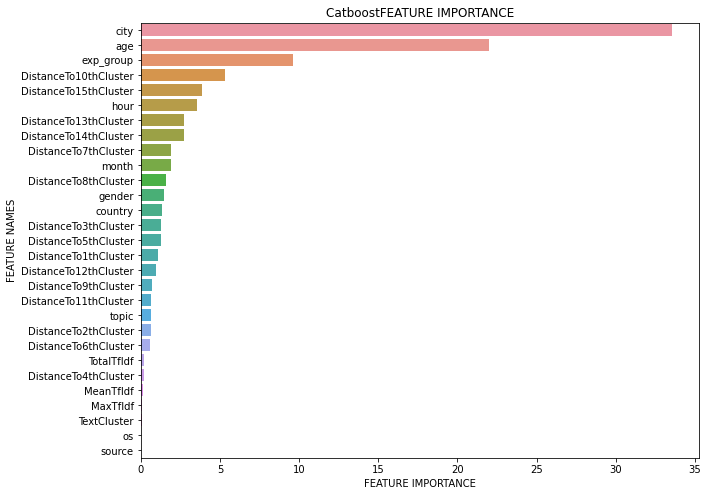

In [27]:
# Посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):
    
    #Создаем массивы на основе важности объектов и их названий
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Создаем DataFrame, используя словарь
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Отсортируем DataFrame в порядке уменьшения важности признаков
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    # Построим график
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')

In [28]:
# Сохраним модель

catboost.save_model(
    'catboost_model',
    format="cbm"                  
)

### Положим в базу фичи, необходимые для функционала нашей модели

In [29]:
posts_info.to_sql(    
   "posts_info_features",                    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",                      
    schema="public",                   
    if_exists='replace'            
   )                               
                                   

In [30]:
# Проверим данные

test_ = pd.read_sql(
    """SELECT * FROM public.posts_info_features""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

test_

,index,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,6,0.480950,0.393620,...,0.508004,0.153318,0.499247,0.528825,0.531872,0.535601,0.451062,0.440469,0.467098,0.545162
1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,1,0.347944,0.166929,...,0.425945,0.265324,0.384865,0.417226,0.283954,0.433196,0.305134,0.288670,0.340473,0.448996
2,2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,6,0.363351,0.230754,...,0.430344,0.127246,0.398547,0.432524,0.479071,0.449855,0.342907,0.319707,0.345712,0.478959
3,3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,1,0.324441,0.144675,...,0.406850,0.230317,0.330804,0.385887,0.433351,0.417854,0.290832,0.283966,0.308295,0.444929
4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,1,0.260389,0.100852,...,0.353807,0.285260,0.296983,0.343361,0.391938,0.406265,0.236587,0.211668,0.240808,0.399030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7017,7314,Although the likeliness of someone focusing on...,movie,10.326422,0.300231,0.000224,2,0.416062,0.465096,...,0.555633,0.540856,0.537535,0.561900,0.575729,0.593421,0.501703,0.464257,0.330313,0.575129
7019,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,6.703302,0.258412,0.000146,2,0.316078,0.348193,...,0.458440,0.437569,0.427332,0.446996,0.492582,0.501991,0.398535,0.340658,0.163186,0.488436
7020,7020,7317,I cant believe this film was allowed to be mad...,movie,5.628524,0.573061,0.000122,0,0.066158,0.265658,...,0.406119,0.379566,0.346612,0.380274,0.453195,0.456691,0.330864,0.272226,0.191601,0.399685
7021,7021,7318,The version I saw of this film was the Blockbu...,movie,6.883375,0.231244,0.000150,0,0.173979,0.282669,...,0.406900,0.384117,0.382882,0.411217,0.449207,0.471032,0.347985,0.294180,0.179641,0.361943
